In [118]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [53]:
SYM = '^IXIC'  # Nasdaq
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_nas.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%%**********************]  1 of 1 completed


Generating derived columns...
(13474, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,4.605170,1.0,1.008400,1.008400
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,4.613535,1.0,0.999207,0.999207
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,4.612741,1.0,0.999305,0.999305
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,4.612047,1.0,1.007548,1.007548
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,4.619566,1.0,1.005914,1.005914
1971-02-12,102.050003,102.050003,102.050003,102.050003,102.050003,4.625463,1.0,1.001372,1.001372
1971-02-16,102.190002,102.190002,102.190002,102.190002,102.190002,4.626834,1.0,0.995596,0.995596
1971-02-17,101.739998,101.739998,101.739998,101.739998,101.739998,4.622421,1.0,0.996855,0.996855
1971-02-18,101.419998,101.419998,101.419998,101.419998,101.419998,4.619270,1.0,0.992901,0.992901


In [54]:
df.high[(df.high != df.low)]

Date
1984-10-11      244.699997
1984-10-12      246.199997
1984-10-15      247.699997
1984-10-16      247.899994
1984-10-17      247.100006
                  ...     
2024-07-08    18416.939453
2024-07-09    18511.890625
2024-07-10    18655.189453
2024-07-11    18671.070312
2024-07-12    18556.730469
Name: high, Length: 10015, dtype: float64

In [55]:
SIM_START = pd.to_datetime('1984-10-11')  # first day of legit open/close values
SIM_START

Timestamp('1984-10-11 00:00:00')

In [56]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [57]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [58]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

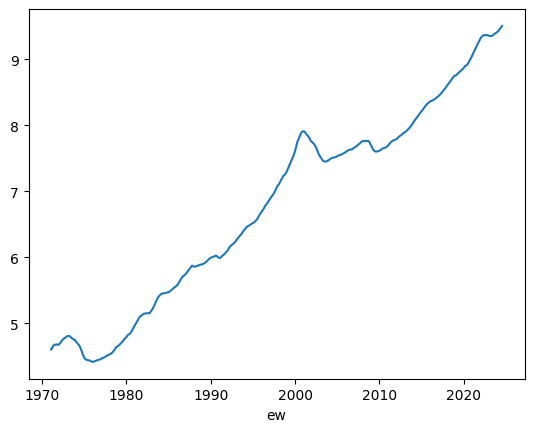

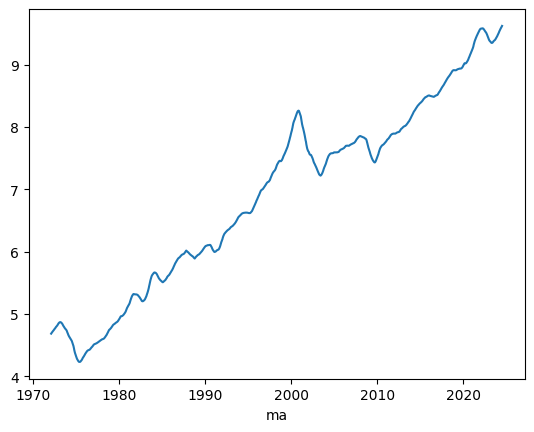

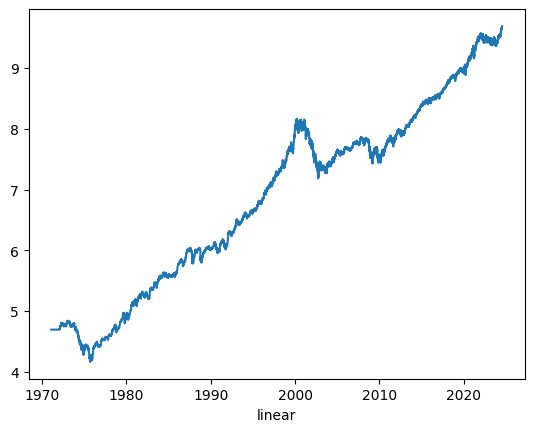

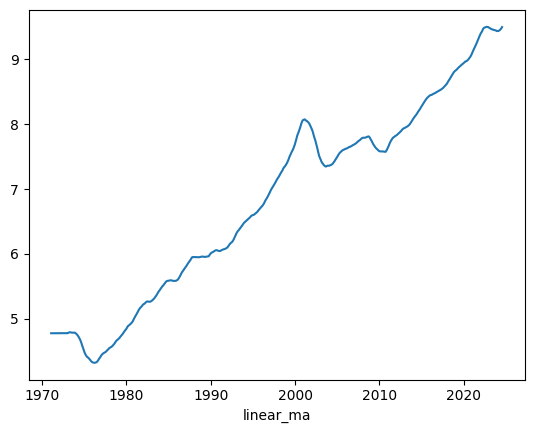

In [59]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [60]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [61]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [62]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [63]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [64]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [65]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(975.8872292729495,
 {'time_param': 235,
  'method': 'ew',
  't': 0.9463760835823656,
  'k': 0.32311302589657903,
  'as_q': False,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 75.18777870128685
Round 1: 975.8891846748882
New best: 975.8891846748882
{'time_param': 235, 'method': 'ew', 't': 0.9463760835823656, 'k': 0.32311302589657903, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


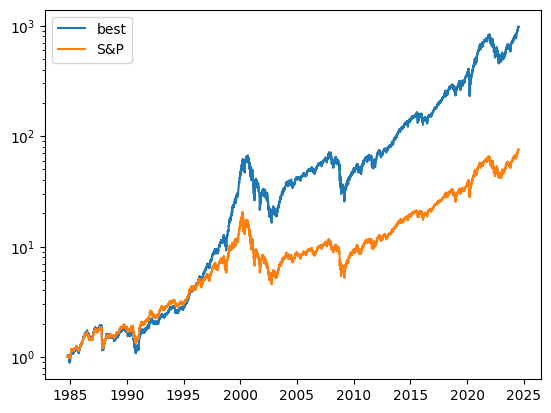

Round 2: 18.471963181120408
Round 3: 1.5008173391409318
Round 4: 245.62336919346768
Round 5: 91.53448829538837
Round 6: 3063.9039969525234
New best: 3063.9039969525234
{'time_param': 194, 'method': 'linear', 't': 0.6664299382396498, 'k': 4.324173608530101, 'as_q': False, 'transform_f': 'bounded_curve'}


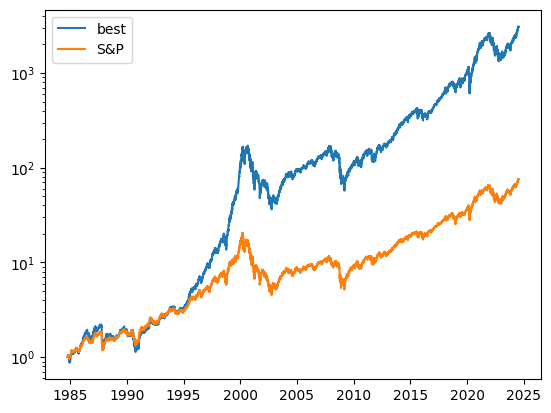

Round 7: 813.9680958922074
Round 8: 4.291364537016902
Round 9: 0.8612758402751456
Round 10: 117.7668318189355
Round 11: 1.0582494209845794
Round 12: 12.955879891431573
Round 13: 235.8628205742666
Round 14: 17.441775582646475
Round 15: 7.935291345642215
Round 16: 1.3853485081081798
Round 17: 229.0887833946497
Round 18: 6.719116292459525
Round 19: 3803.497032007675
New best: 3803.497032007675
{'time_param': 160, 'method': 'linear_ma', 't': 0.9455856248421314, 'k': 2.924506374527197, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


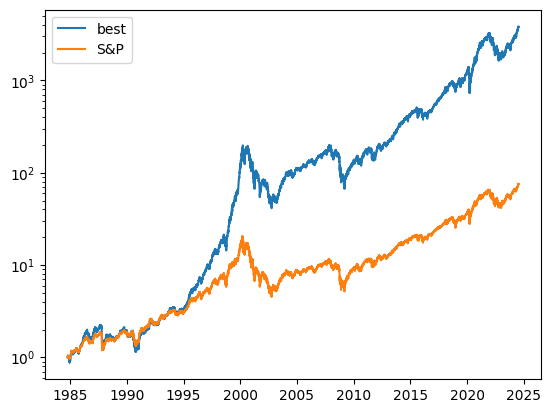

Round 20: 401.37461098812867
Round 21: 60.99682767904375
Round 22: 664.7899568399998
Round 23: 3.2418611235098687
Round 24: 10.374093063321418
Round 25: 1391.0488068425811
Round 26: 87.87052705131657
Round 27: 1.827434042711226
Round 28: 452.62058090506775
Round 29: 1.3420474661566497
Round 30: 77.1893185090235
Round 31: 1862.714652409058
Round 32: 490.2713967203328
Round 33: 2.727641816782337
Round 34: 3323.7192662783827
Round 35: 2.715178293737218
Round 36: 30.316197051093226
Round 37: 67.28965090193282
Round 38: 20.258416824239234
Round 39: 2998.7536975100707
Round 40: 3859.1649851487164
New best: 3859.1649851487164
{'time_param': 194, 'method': 'linear', 't': 0.9956639325970832, 'k': 0.11619836300817706, 'as_q': False, 'transform_f': 'bounded_sigmoid'}


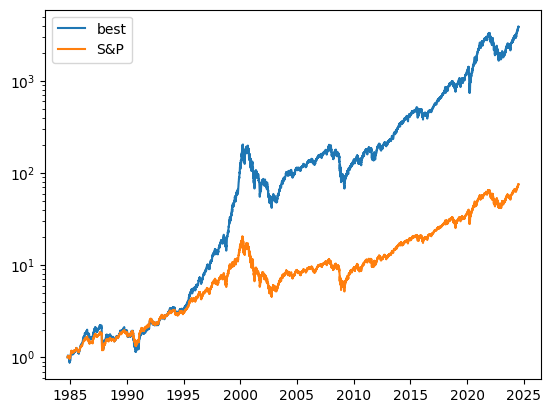

Round 41: 98.52686997361485
Round 42: 40.3943373335967
Round 43: 3.885344116327702
Round 44: 62.240667643630665
Round 45: 88.600382976766
Round 46: 2.147826978454345
Round 47: 2684.9739054541833
Round 48: 40.512518310186586
Round 49: 83.04282498634178
Round 50: 88.23835658490609
Round 51: 2300.7629501650763
Round 52: 1.2278727050122376
Round 53: 41.69097114290073
Round 54: 44.879151099659474
Round 55: 162.44513054425153
Round 56: 2.1074940973015135
Round 57: 40.119315585639676
Round 58: 47.08668888233035
Round 59: 2.097948682846661
Round 60: 2812.268225314917
Round 61: 23.25706182531959
Round 62: 79.93465913494558
Round 63: 1.432454065139977
Round 64: 2.2356479149552633
Round 65: 1179.7156892985636
Round 66: 1.139529095209919
Round 67: 45.33004123283935
Round 68: 1.0701122732515382
Round 69: 68.4775607648842
Round 70: 1.119578187095499
Round 71: 47.664787466069384
Round 72: 53.778154388351965
Round 73: 587.3656952084891
Round 74: 28.192739142407603
Round 75: 8.845476154576366
Round 76:

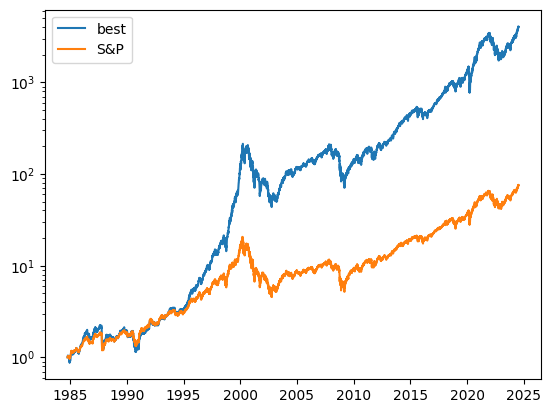

Round 89: 97.68605247040497
Round 90: 3868.831779894838
Round 91: 1.2191526073212842
Round 92: 4.125422049300553
Round 93: 45.66612343421971
Round 94: 48.03591974638768
Round 95: 650.8961781392866
Round 96: 3.439097714682727
Round 97: 1.3410027609569115
Round 98: 205.12886303093953
Round 99: 97.72688585179358
Round 100: 1837.4020299372821


In [66]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 75.18777870128685
Round 1: 4001.8106863288813
Round 2: 4001.796546804039
Round 3: 4001.7773687376516
Round 4: 4001.831633811803
Round 5: 3000.167296133426
Round 6: 4001.8046803587517
Round 7: 4001.7725311662516
Round 8: 4001.8114504962336
Round 9: 899.467684434894
Round 10: 3169.784097487478
Round 11: 1482.1286229248046
Round 12: 4001.770347037618
Round 13: 109.93030725792053
Round 14: 3468.224346560246
Round 15: 1913.4628026238279
Round 16: 4001.805927526852
Round 17: 2949.6156963655
Round 18: 2496.9355452076716
Round 19: 4001.8074547572237
Round 20: 4005.8196251134164
Round 21: 3978.2628134445295
Round 22: 4022.0935910026137
New best: 4022.0935910026137
{'time_param': 198, 'method': 'linear_ma', 't': 0.9792676726309202, 'k': 7.204335011943023, 'as_q': False, 'transform_f': 'bounded_curve'}


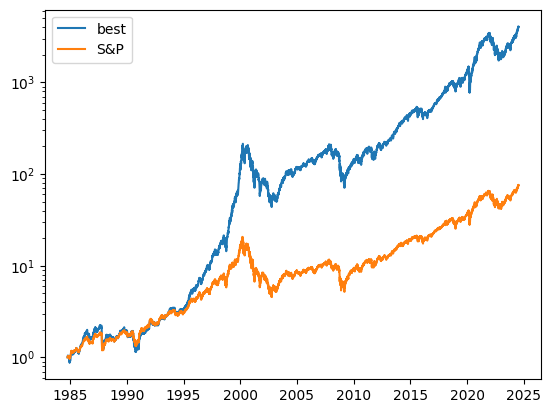

Round 23: 2713.5980665577667
Round 24: 4001.7616861612905
Round 25: 4001.8033930104857

Factor: 1.03125
Do nothing res: 75.18777870128685
Round 1: 3976.7116218099563
Round 2: 3153.565885689074
Round 3: 3497.3646522274453
Round 4: 4001.7934109273997
Round 5: 3832.6647748721934
Round 6: 2250.213811904237
Round 7: 4001.761558817035
Round 8: 2735.902601983352
Round 9: 466.6041853337962
Round 10: 3273.7915921240224
Round 11: 4001.782715097546
Round 12: 2345.0160355733706
Round 13: 4012.5537566008647
Round 14: 4001.78599283488
Round 15: 3662.5681888872914
Round 16: 4001.786035334042
Round 17: 4001.7857705797555
Round 18: 3482.8724494164276
Round 19: 3949.7410865446896
Round 20: 4001.7812948034843
Round 21: 4001.7848328928876
Round 22: 4001.763498168972
Round 23: 3456.5986194914844
Round 24: 4001.779383798518
Round 25: 4014.9221204288438

Factor: 1.015625
Do nothing res: 75.18777870128685
Round 1: 4001.7738672275295
Round 2: 3847.764002655463
Round 3: 3639.7266077172126
Round 4: 4001.77533795

In [67]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [68]:
stop

NameError: name 'stop' is not defined

In [101]:
# Force set:
#best_out = 3063.9039969525234
#params_out = {'time_param': 194, 'method': 'linear', 't': 0.6664299382396498, 'k': 4.324173608530101, 'as_q': False, 'transform_f': 'bounded_curve'}

In [102]:
final_out = simulate(df, params_out)

In [103]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9612541279500277

In [104]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.6439492987344508

In [105]:
params_out

{'time_param': 194,
 'method': 'linear',
 't': 0.6664299382396498,
 'k': 4.324173608530101,
 'as_q': False,
 'transform_f': 'bounded_curve'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:24: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + x**(np.log(2) / np.log(t)) - 1) ** k


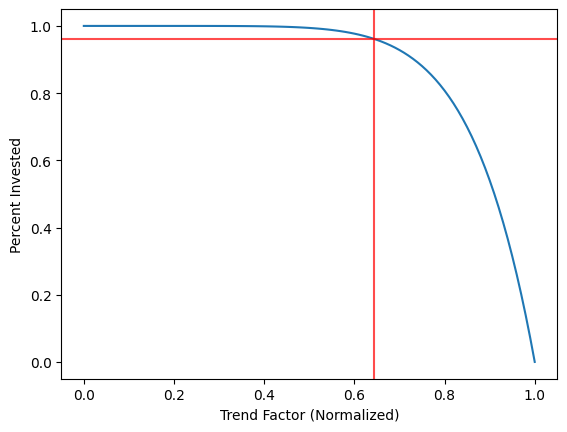

In [106]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

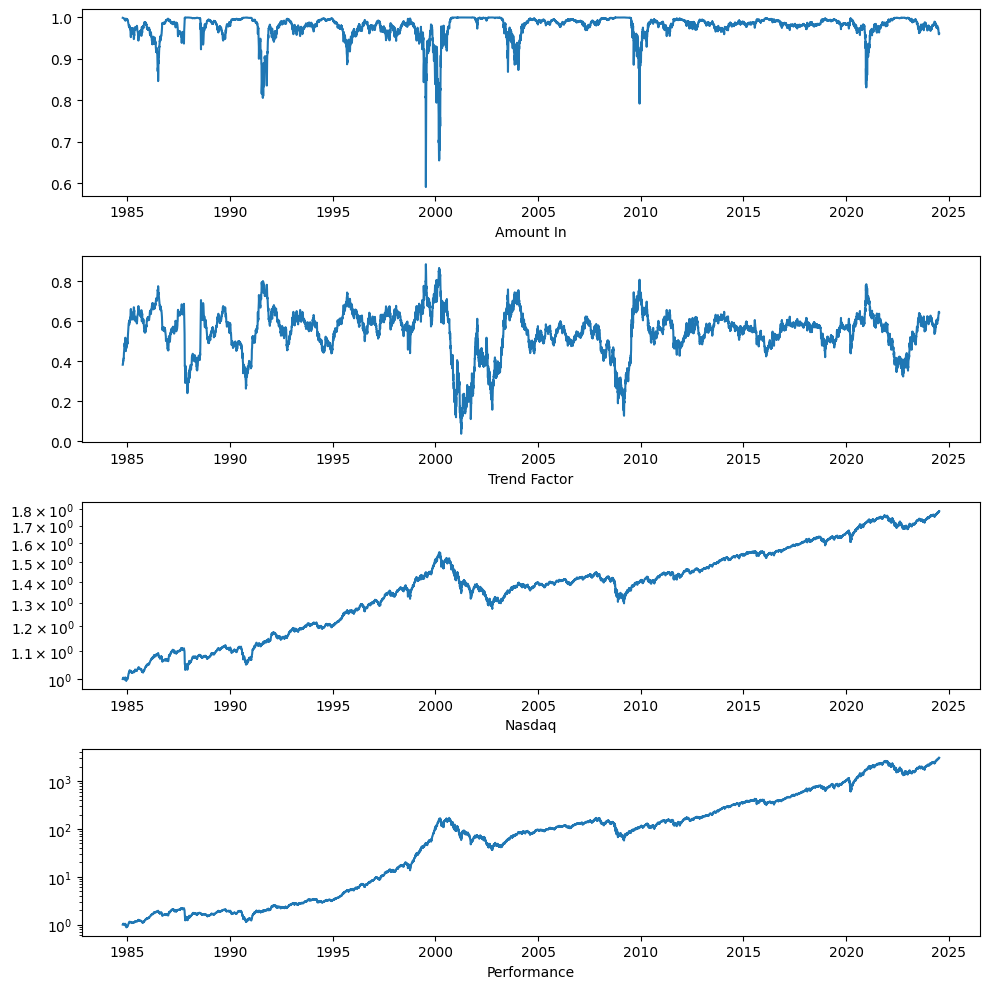

In [107]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('Nasdaq')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [108]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Nasdaq')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

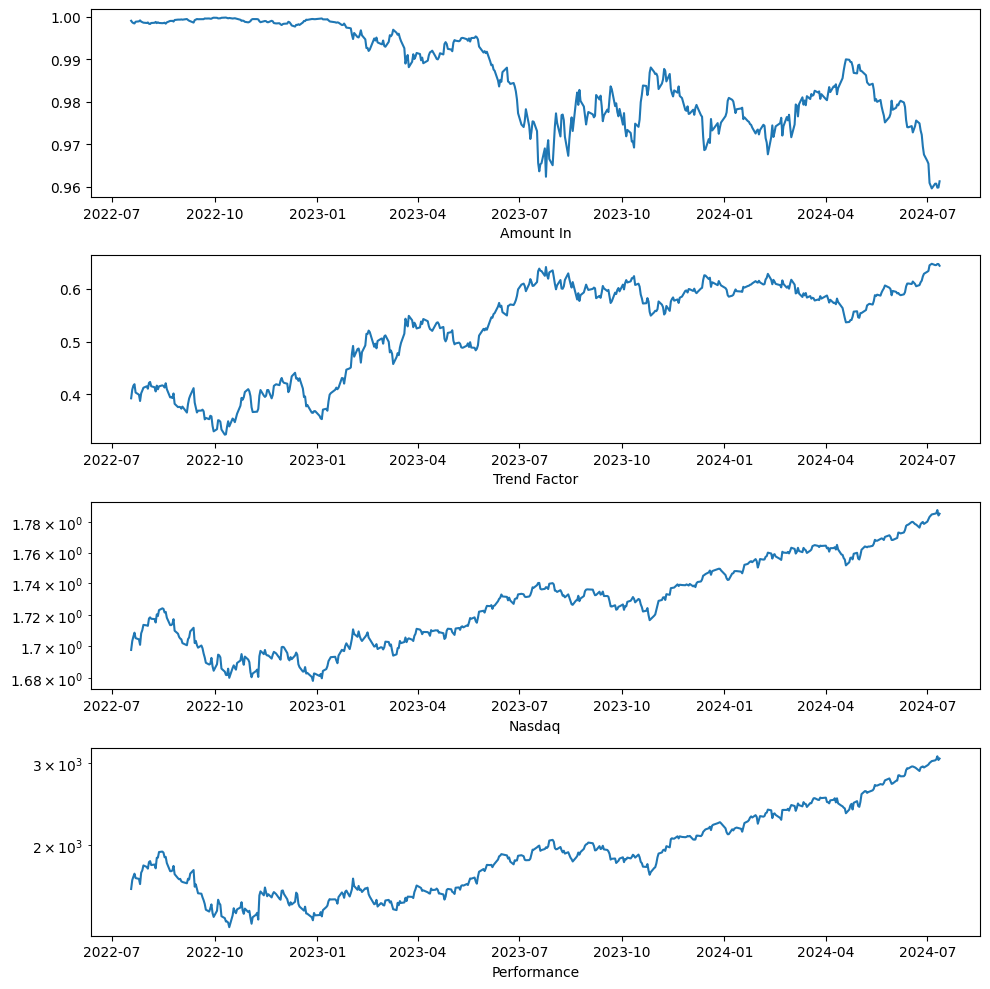

In [109]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('Nasdaq')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [110]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(3063.9039969525234,
 {'time_param': 194,
  'method': 'linear',
  't': 0.6664299382396498,
  'k': 4.324173608530101,
  'as_q': False,
  'transform_f': 'bounded_curve'})

In [117]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

0.9613

In [112]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(244.6999969482422, 40.068, 18398.44921875)

In [116]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.2218248776758529

In [122]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['nas'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.117876849072677, 0.9707], 'nas': [1.221824877675853, 0.9613]}
